In [2]:
import os
os.chdir('..')

In [155]:
pwd

'/mnt/md1/user_victor/automatic_melody_harmonization'

In [121]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from constants import Constants

In [5]:

# chord_seqs = np.load('./data/number_96.npy')
length = np.load('./data/length.npy')
chord_seqs = np.load('./data/chord_indices.npy')

In [9]:
chord_seq = chord_seqs[:5]

In [11]:
chord_seq.shape

(5, 272, 1)

In [150]:
class markov_chain(): 
    def __init__(self,chord_seqs,length,all_chords=False):
        
        self.chord_seqs = chord_seqs
        self.length = length
        # All chords or not
        if all_chords:
            self.states = [x for x in range(Constants.ALL_NUM_CHORDS)]
        else:
            self.states = [x for x in range(Constants.NUM_CHORDS)]
            
        self.num_state = len(self.states) #number of states
        self.M = [[0]*self.num_state for _ in range(self.num_state)]
        self.blank_M = [[0]*self.num_state for _ in range(self.num_state)]
    
    # Input one seq
    def transition_probability(self,seq):
#         M = [[0]*self.num_state for _ in range(self.num_state)]
        
        # Convert seq to index seq
#         index_seq = [self.states.index(i) for i in seq]
        index_seq = np.squeeze(seq,axis=-1).tolist()

        for (i,j) in zip(index_seq,index_seq[1:]):
            self.M[i][j] += 1

        #now convert to probabilities:
        for row in self.M:
            s = sum(row)
            if s > 0:
                row[:] = [f/s for f in row]
    
    # Input one seq
    def create_transition_matrix_by_one_seq(self,seq):
        self.transition_probability(seq)
        return np.array(self.M)
    
    # Input seqs
    def create_transition_matrix_by_many_seqs(self):
        for seq in self.chord_seqs:
            self.transition_probability(seq)
        return np.array(self.M)
    
    # Input one seq
    def calculate_surprisingness(self,seq,t,TM):
        
        current = seq[t]
        i_ = self.states.index(current)

        previous = seq[t - 1]
        j_ = self.states.index(previous)

        if TM[i_][j_] == 0:
            surprisingness = -np.log(TM[i_][j_] + 1e-4)
        else:
            surprisingness = -np.log(TM[i_][j_])
            
        return surprisingness
    
    def create_surprisingness_seqs(self,average_TM=False):
    
        surprisingness_seqs = []
        n = len(self.chord_seqs)
        
        if average_TM:
            TM = self.create_transition_matrix_by_many_seqs().transpose()
            
        for i in tqdm(range(n)):
            seq = self.chord_seqs[i]
            T = range(1,self.length[i])
            surprisingness_seq = [0]

            if average_TM:
                for t in T:
                    surprisingness = self.calculate_surprisingness(seq,t,TM)
                    surprisingness_seq.append(surprisingness)
                
            else:
                for t in T:
                    TM = self.create_transition_matrix_by_one_seq(seq[:t]).transpose()
                    self.M = self.blank_M
                    surprisingness = self.calculate_surprisingness(seq,t,TM)
                    surprisingness_seq.append(surprisingness)
                   
            surprisingness_seqs.append(np.asarray(surprisingness_seq))
        
        # Pad 0 to the positions if the length of chord sequence is smaller than max length               
        for i in tqdm(range(len(surprisingness_seqs))):
            surprisingness_seqs[i] = np.pad(surprisingness_seqs[i], (0, Constants.MAX_SEQUENCE_LENGTH - surprisingness_seqs[i].shape[0]),'constant', constant_values = 0)
       
        # Convert all lists to np arrays
        surprisingness_seqs = np.asarray(surprisingness_seqs)
        surprisingness_seqs = np.expand_dims(surprisingness_seqs,axis=-1)

        return surprisingness_seqs, TM
    

In [151]:
## Print data 
surprisingness_seqs, TM = markov_chain(chord_seq,length[:5],all_chords = True).create_surprisingness_seqs(average_TM = False)

100%|██████████| 5/5 [00:00<00:00, 9808.94it/s]


17


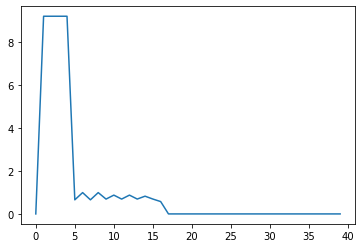

In [160]:
i = 0
l = length[i]
s = surprisingness_seqs[i]
fig, ax = plt.subplots()
ax.plot(s[:40])
print(l)

In [76]:
a = np.array([[2],[3]])
b = a.tolist()

In [77]:
b

[[2], [3]]

In [156]:
surprisingness_seqs = np.load('./data/surprisingness_96.npy')

In [116]:
surprisingness_seqs.shape

(17430, 272, 1)

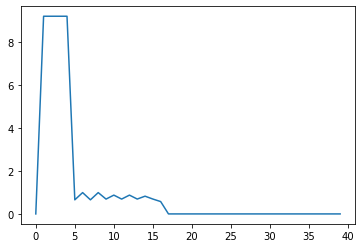

In [159]:
l = length[i]
s = surprisingness_seqs[i]
fig, ax = plt.subplots()
ax.plot(s[:40])

In [33]:
## Create Markov Chain for the whole data
seq = chord_seqs[i]
states = [x for x in range(96)]
transition_matrix(seq,states).create()
   
  

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [55]:
TM

array([[9.99983136e-01, 1.01443500e-05, 2.54629630e-01, ...,
        2.05555556e-01, 7.41767215e-02, 1.04166748e-04],
       [2.89193030e-46, 6.23823421e-01, 0.00000000e+00, ...,
        4.62962964e-06, 0.00000000e+00, 3.68019755e-13],
       [0.00000000e+00, 0.00000000e+00, 5.92592593e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.58651391e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.37620621e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.59732487e-03]])

In [66]:
TM

array([[9.99983136e-01, 1.01443500e-05, 2.54629630e-01, ...,
        2.05555556e-01, 7.41767215e-02, 1.04166748e-04],
       [2.89193030e-46, 6.23823421e-01, 0.00000000e+00, ...,
        4.62962964e-06, 0.00000000e+00, 3.68019755e-13],
       [0.00000000e+00, 0.00000000e+00, 5.92592593e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.58651391e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.37620621e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.59732487e-03]])

In [89]:
i = 20
surprisingness_seqs_ = []
# n = len(chord_seqs)
n = len(chord_seqs[0])
states = [x for x in range(96)]

# for i in tqdm(range(n)):

seq = chord_seqs[i]
N = len(seq)
T = range(1,N)
surprisingness_seq = [0]

for t in T:
    
    current = seq[t]
    i_ = states.index(current)

    previous = seq[t - 1]
    j_ = states.index(previous)

    if TM[i_][j_] == 0:
            surprisingness = -np.log(TM[i_][j_] + 1e-4)
    else:
        surprisingness = -np.log(TM[i_][j_])
    surprisingness_seq.append(surprisingness)

surprisingness_seqs_.append(surprisingness_seq)
surprisingness_seqs_ = np.array(surprisingness_seqs_)

In [81]:
surprisingness_seqs_.shape

(1, 272)

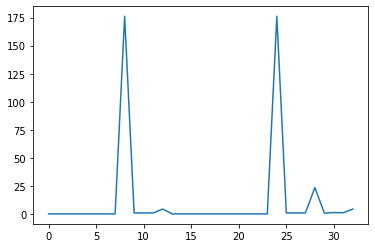

In [90]:
l = length[i]
s = surprisingness_seqs_[0]
fig, ax = plt.subplots()
ax.plot(s[:l])

In [71]:
i = 1
l = length[i]
s = surprisingness_seqs[i]
fig, ax = plt.subplots()
ax.plot(s[:l])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
TM